In [1]:
import os
import numpy as np
import h5py
from sklearn.model_selection import train_test_split
from collections import Counter
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import matplotlib.pyplot as plt
import json

# Define a custom callback to print messages and store history
class PrintLogger(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"\nEpoch {epoch + 1} started.")
    
    def on_epoch_end(self, epoch, logs=None):
        print(f"\nEpoch {epoch + 1} ended.")
        print(f"Accuracy: {logs['accuracy']:.4f} - Loss: {logs['loss']:.4f} - Val Accuracy: {logs['val_accuracy']:.4f} - Val Loss: {logs['val_loss']:.4f}")

# Define directories
save_dir = './split_datav3'
os.makedirs(save_dir, exist_ok=True)

# Load the split data
X_rp_train = np.load(os.path.join(save_dir, 'X_rp_train.npy'))
X_gaf_train = np.load(os.path.join(save_dir, 'X_gaf_train.npy'))
X_mtf_train = np.load(os.path.join(save_dir, 'X_mtf_train.npy'))
y_train = np.load(os.path.join(save_dir, 'y_train.npy'))

X_rp_val = np.load(os.path.join(save_dir, 'X_rp_val.npy'))
X_gaf_val = np.load(os.path.join(save_dir, 'X_gaf_val.npy'))
X_mtf_val = np.load(os.path.join(save_dir, 'X_mtf_val.npy'))
y_val = np.load(os.path.join(save_dir, 'y_val.npy'))

X_rp_test = np.load(os.path.join(save_dir, 'X_rp_test.npy'))
X_gaf_test = np.load(os.path.join(save_dir, 'X_gaf_test.npy'))
X_mtf_test = np.load(os.path.join(save_dir, 'X_mtf_test.npy'))
y_test = np.load(os.path.join(save_dir, 'y_test.npy'))

# Resize images to (224, 224, 3) and keep only RGB channels
def resize_images(images):
    resized_images = []
    for img in images:
        img = tf.image.resize(img, [224, 224])
        img = img[:, :, :3]  # Keep only RGB channels
        resized_images.append(img)
    return np.array(resized_images)

X_rp_train = resize_images(X_rp_train)
X_gaf_train = resize_images(X_gaf_train)
X_mtf_train = resize_images(X_mtf_train)
X_rp_val = resize_images(X_rp_val)
X_gaf_val = resize_images(X_gaf_val)
X_mtf_val = resize_images(X_mtf_val)
X_rp_test = resize_images(X_rp_test)
X_gaf_test = resize_images(X_gaf_test)
X_mtf_test = resize_images(X_mtf_test)

# Define a function to build the ResNet50 model
def build_resnet50_model(input_shape, num_classes):
    inputs_rp = Input(shape=input_shape, name='input_rp')
    inputs_gaf = Input(shape=input_shape, name='input_gaf')
    inputs_mtf = Input(shape=input_shape, name='input_mtf')

    base_rp = ResNet50(include_top=False, input_tensor=inputs_rp, weights='imagenet', pooling='avg')
    base_gaf = ResNet50(include_top=False, input_tensor=inputs_gaf, weights='imagenet', pooling='avg')
    base_mtf = ResNet50(include_top=False, input_tensor=inputs_mtf, weights='imagenet', pooling='avg')

    x_rp = base_rp.output
    x_gaf = base_gaf.output
    x_mtf = base_mtf.output

    merged = Concatenate(name='concat')([x_rp, x_gaf, x_mtf])

    x = Dense(512, activation='relu', name='dense_512')(merged)
    x = Dropout(0.5, name='dropout_512')(x)
    x = Dense(128, activation='relu', name='dense_128')(x)
    x = Dropout(0.5, name='dropout_128')(x)
    outputs = Dense(num_classes, activation='softmax', name='output')(x)

    model = Model(inputs=[inputs_rp, inputs_gaf, inputs_mtf], outputs=outputs)
    return model

# Define input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 5

# Build ResNet50 model
resnet50_model = build_resnet50_model(input_shape, num_classes)
resnet50_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
resnet50_checkpoint = ModelCheckpoint(filepath=os.path.join(save_dir, 'resnet50_best_model.h5'), monitor='val_loss', save_best_only=True)

# Train ResNet50 model
resnet50_history = resnet50_model.fit(
    [X_rp_train, X_gaf_train, X_mtf_train], y_train,
    epochs=10, batch_size=32, validation_data=([X_rp_val, X_gaf_val, X_mtf_val], y_val),
    callbacks=[early_stopping, resnet50_checkpoint, PrintLogger()],
    verbose=1
)

# Evaluate ResNet50 model on the test set
resnet50_model.load_weights(os.path.join(save_dir, 'resnet50_best_model.h5'))
resnet50_test_loss, resnet50_test_accuracy = resnet50_model.evaluate([X_rp_test, X_gaf_test, X_mtf_test], y_test)
print(f'ResNet50 Test loss: {resnet50_test_loss:.4f}')
print(f'ResNet50 Test accuracy: {resnet50_test_accuracy:.4f}')

# Function to plot learning curves
def plot_learning_curve(history, model_name):
    plt.figure(figsize=(12, 8))

    # Plot training & validation accuracy values
    plt.subplot(2, 1, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model accuracy - {model_name}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model loss - {model_name}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Plot learning curve for ResNet50
plot_learning_curve(resnet50_history, 'ResNet50')

# Save the final ResNet50 model
resnet50_model.save(os.path.join(save_dir, 'resnet50_model.h5'))

# Save the training history
with open(os.path.join(save_dir, 'resnet50_history.json'), 'w') as f:
    json.dump(resnet50_history.history, f)

print(f"ResNet50 model and history saved in directory: {save_dir}")


2024-07-01 15:17:03.788426: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-01 15:17:03.799389: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-01 15:17:03.815290: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-01 15:17:03.815314: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-01 15:17:03.825334: I tensorflow/core/platform/cpu_feature_gua

ValueError: The name "conv1_pad" is used 3 times in the model. All operation names should be unique.

In [3]:
#Debugging
import os
import numpy as np
import h5py
from sklearn.model_selection import train_test_split
from collections import Counter
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, clone_model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import matplotlib.pyplot as plt
import json

# Define a custom callback to print messages and store history
class PrintLogger(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"\nEpoch {epoch + 1} started.")
    
    def on_epoch_end(self, epoch, logs=None):
        print(f"\nEpoch {epoch + 1} ended.")
        print(f"Accuracy: {logs['accuracy']:.4f} - Loss: {logs['loss']:.4f} - Val Accuracy: {logs['val_accuracy']:.4f} - Val Loss: {logs['val_loss']:.4f}")

# Define directories
save_dir = './split_datav3'
os.makedirs(save_dir, exist_ok=True)

# Load the split data
X_rp_train = np.load(os.path.join(save_dir, 'X_rp_train.npy'))
X_gaf_train = np.load(os.path.join(save_dir, 'X_gaf_train.npy'))
X_mtf_train = np.load(os.path.join(save_dir, 'X_mtf_train.npy'))
y_train = np.load(os.path.join(save_dir, 'y_train.npy'))

X_rp_val = np.load(os.path.join(save_dir, 'X_rp_val.npy'))
X_gaf_val = np.load(os.path.join(save_dir, 'X_gaf_val.npy'))
X_mtf_val = np.load(os.path.join(save_dir, 'X_mtf_val.npy'))
y_val = np.load(os.path.join(save_dir, 'y_val.npy'))

X_rp_test = np.load(os.path.join(save_dir, 'X_rp_test.npy'))
X_gaf_test = np.load(os.path.join(save_dir, 'X_gaf_test.npy'))
X_mtf_test = np.load(os.path.join(save_dir, 'X_mtf_test.npy'))
y_test = np.load(os.path.join(save_dir, 'y_test.npy'))

# Resize images to (224, 224, 3) and keep only RGB channels
def resize_images(images):
    resized_images = []
    for img in images:
        img = tf.image.resize(img, [224, 224])
        img = img[:, :, :3]  # Keep only RGB channels
        resized_images.append(img)
    return np.array(resized_images)

X_rp_train = resize_images(X_rp_train)
X_gaf_train = resize_images(X_gaf_train)
X_mtf_train = resize_images(X_mtf_train)
X_rp_val = resize_images(X_rp_val)
X_gaf_val = resize_images(X_gaf_val)
X_mtf_val = resize_images(X_mtf_val)
X_rp_test = resize_images(X_rp_test)
X_gaf_test = resize_images(X_gaf_test)
X_mtf_test = resize_images(X_mtf_test)

# Define a function to build the ResNet50 model using clone_model
def build_resnet50_model(input_shape, num_classes):
    inputs_rp = Input(shape=input_shape, name='input_rp')
    inputs_gaf = Input(shape=input_shape, name='input_gaf')
    inputs_mtf = Input(shape=input_shape, name='input_mtf')

    base_model = ResNet50(include_top=False, weights='imagenet', pooling='avg')

    base_rp = clone_model(base_model)
    base_rp.set_weights(base_model.get_weights())
    x_rp = base_rp(inputs_rp)

    base_gaf = clone_model(base_model)
    base_gaf.set_weights(base_model.get_weights())
    x_gaf = base_gaf(inputs_gaf)

    base_mtf = clone_model(base_model)
    base_mtf.set_weights(base_model.get_weights())
    x_mtf = base_mtf(inputs_mtf)

    merged = Concatenate(name='concat')([x_rp, x_gaf, x_mtf])

    x = Dense(512, activation='relu', name='dense_512')(merged)
    x = Dropout(0.5, name='dropout_512')(x)
    x = Dense(128, activation='relu', name='dense_128')(x)
    x = Dropout(0.5, name='dropout_128')(x)
    outputs = Dense(num_classes, activation='softmax', name='output')(x)

    model = Model(inputs=[inputs_rp, inputs_gaf, inputs_mtf], outputs=outputs)
    return model

# Define input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 5

# Build ResNet50 model
resnet50_model = build_resnet50_model(input_shape, num_classes)
resnet50_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
resnet50_checkpoint = ModelCheckpoint(filepath=os.path.join(save_dir, 'resnet50_best_model.h5'), monitor='val_loss', save_best_only=True)

# Train ResNet50 model
resnet50_history = resnet50_model.fit(
    [X_rp_train, X_gaf_train, X_mtf_train], y_train,
    epochs=10, batch_size=32, validation_data=([X_rp_val, X_gaf_val, X_mtf_val], y_val),
    callbacks=[early_stopping, resnet50_checkpoint, PrintLogger()],
    verbose=1
)

# Evaluate ResNet50 model on the test set
resnet50_model.load_weights(os.path.join(save_dir, 'resnet50_best_model.h5'))
resnet50_test_loss, resnet50_test_accuracy = resnet50_model.evaluate([X_rp_test, X_gaf_test, X_mtf_test], y_test)
print(f'ResNet50 Test loss: {resnet50_test_loss:.4f}')
print(f'ResNet50 Test accuracy: {resnet50_test_accuracy:.4f}')

# Function to plot learning curves
def plot_learning_curve(history, model_name):
    plt.figure(figsize=(12, 8))

    # Plot training & validation accuracy values
    plt.subplot(2, 1, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model accuracy - {model_name}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model loss - {model_name}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Plot learning curve for ResNet50
plot_learning_curve(resnet50_history, 'ResNet50')

# Save the final ResNet50 model
resnet50_model.save(os.path.join(save_dir, 'resnet50_model.h5'))

# Save the training history
with open(os.path.join(save_dir, 'resnet50_history.json'), 'w') as f:
    json.dump(resnet50_history.history, f)

print(f"ResNet50 model and history saved in directory: {save_dir}")


ValueError: The name "resnet50" is used 3 times in the model. All operation names should be unique.

In [4]:
#debug
import os
import numpy as np
import h5py
from sklearn.model_selection import train_test_split
from collections import Counter
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, clone_model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import matplotlib.pyplot as plt
import json

# Define a custom callback to print messages and store history
class PrintLogger(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"\nEpoch {epoch + 1} started.")
    
    def on_epoch_end(self, epoch, logs=None):
        print(f"\nEpoch {epoch + 1} ended.")
        print(f"Accuracy: {logs['accuracy']:.4f} - Loss: {logs['loss']:.4f} - Val Accuracy: {logs['val_accuracy']:.4f} - Val Loss: {logs['val_loss']:.4f}")

# Define directories
save_dir = './split_datav3'
os.makedirs(save_dir, exist_ok=True)

# Load the split data
X_rp_train = np.load(os.path.join(save_dir, 'X_rp_train.npy'))
X_gaf_train = np.load(os.path.join(save_dir, 'X_gaf_train.npy'))
X_mtf_train = np.load(os.path.join(save_dir, 'X_mtf_train.npy'))
y_train = np.load(os.path.join(save_dir, 'y_train.npy'))

X_rp_val = np.load(os.path.join(save_dir, 'X_rp_val.npy'))
X_gaf_val = np.load(os.path.join(save_dir, 'X_gaf_val.npy'))
X_mtf_val = np.load(os.path.join(save_dir, 'X_mtf_val.npy'))
y_val = np.load(os.path.join(save_dir, 'y_val.npy'))

X_rp_test = np.load(os.path.join(save_dir, 'X_rp_test.npy'))
X_gaf_test = np.load(os.path.join(save_dir, 'X_gaf_test.npy'))
X_mtf_test = np.load(os.path.join(save_dir, 'X_mtf_test.npy'))
y_test = np.load(os.path.join(save_dir, 'y_test.npy'))

# Resize images to (224, 224, 3) and keep only RGB channels
def resize_images(images):
    resized_images = []
    for img in images:
        img = tf.image.resize(img, [224, 224])
        img = img[:, :, :3]  # Keep only RGB channels
        resized_images.append(img)
    return np.array(resized_images)

X_rp_train = resize_images(X_rp_train)
X_gaf_train = resize_images(X_gaf_train)
X_mtf_train = resize_images(X_mtf_train)
X_rp_val = resize_images(X_rp_val)
X_gaf_val = resize_images(X_gaf_val)
X_mtf_val = resize_images(X_mtf_val)
X_rp_test = resize_images(X_rp_test)
X_gaf_test = resize_images(X_gaf_test)
X_mtf_test = resize_images(X_mtf_test)

# Define a function to build the ResNet50 model using clone_model
def build_resnet50_model(input_shape, num_classes):
    inputs_rp = Input(shape=input_shape, name='input_rp')
    inputs_gaf = Input(shape=input_shape, name='input_gaf')
    inputs_mtf = Input(shape=input_shape, name='input_mtf')

    base_model = ResNet50(include_top=False, weights='imagenet', pooling='avg')

    # Clone the base model for each input with unique names
    base_rp = clone_model(base_model)
    base_rp._name = 'base_rp'
    base_rp.set_weights(base_model.get_weights())
    x_rp = base_rp(inputs_rp)

    base_gaf = clone_model(base_model)
    base_gaf._name = 'base_gaf'
    base_gaf.set_weights(base_model.get_weights())
    x_gaf = base_gaf(inputs_gaf)

    base_mtf = clone_model(base_model)
    base_mtf._name = 'base_mtf'
    base_mtf.set_weights(base_model.get_weights())
    x_mtf = base_mtf(inputs_mtf)

    merged = Concatenate(name='concat')([x_rp, x_gaf, x_mtf])

    x = Dense(512, activation='relu', name='dense_512')(merged)
    x = Dropout(0.5, name='dropout_512')(x)
    x = Dense(128, activation='relu', name='dense_128')(x)
    x = Dropout(0.5, name='dropout_128')(x)
    outputs = Dense(num_classes, activation='softmax', name='output')(x)

    model = Model(inputs=[inputs_rp, inputs_gaf, inputs_mtf], outputs=outputs)
    return model

# Define input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 5

# Build ResNet50 model
resnet50_model = build_resnet50_model(input_shape, num_classes)
resnet50_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
resnet50_checkpoint = ModelCheckpoint(filepath=os.path.join(save_dir, 'resnet50_best_model.h5'), monitor='val_loss', save_best_only=True)

# Train ResNet50 model
resnet50_history = resnet50_model.fit(
    [X_rp_train, X_gaf_train, X_mtf_train], y_train,
    epochs=10, batch_size=32, validation_data=([X_rp_val, X_gaf_val, X_mtf_val], y_val),
    callbacks=[early_stopping, resnet50_checkpoint, PrintLogger()],
    verbose=1
)

# Evaluate ResNet50 model on the test set
resnet50_model.load_weights(os.path.join(save_dir, 'resnet50_best_model.h5'))
resnet50_test_loss, resnet50_test_accuracy = resnet50_model.evaluate([X_rp_test, X_gaf_test, X_mtf_test], y_test)
print(f'ResNet50 Test loss: {resnet50_test_loss:.4f}')
print(f'ResNet50 Test accuracy: {resnet50_test_accuracy:.4f}')

# Function to plot learning curves
def plot_learning_curve(history, model_name):
    plt.figure(figsize=(12, 8))

    # Plot training & validation accuracy values
    plt.subplot(2, 1, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model accuracy - {model_name}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model loss - {model_name}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Plot learning curve for ResNet50
plot_learning_curve(resnet50_history, 'ResNet50')

# Save the final ResNet50 model
resnet50_model.save(os.path.join(save_dir, 'resnet50_model.h5'))

# Save the training history
with open(os.path.join(save_dir, 'resnet50_history.json'), 'w') as f:
    json.dump(resnet50_history.history, f)

print(f"ResNet50 model and history saved in directory: {save_dir}")


ValueError: The name "resnet50" is used 3 times in the model. All operation names should be unique.

In [5]:
#debugging
import os
import numpy as np
import h5py
from sklearn.model_selection import train_test_split
from collections import Counter
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import matplotlib.pyplot as plt
import json

# Define a custom callback to print messages and store history
class PrintLogger(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"\nEpoch {epoch + 1} started.")
    
    def on_epoch_end(self, epoch, logs=None):
        print(f"\nEpoch {epoch + 1} ended.")
        print(f"Accuracy: {logs['accuracy']:.4f} - Loss: {logs['loss']:.4f} - Val Accuracy: {logs['val_accuracy']:.4f} - Val Loss: {logs['val_loss']:.4f}")

# Define directories
save_dir = './split_datav3'
os.makedirs(save_dir, exist_ok=True)

# Load the split data
X_rp_train = np.load(os.path.join(save_dir, 'X_rp_train.npy'))
X_gaf_train = np.load(os.path.join(save_dir, 'X_gaf_train.npy'))
X_mtf_train = np.load(os.path.join(save_dir, 'X_mtf_train.npy'))
y_train = np.load(os.path.join(save_dir, 'y_train.npy'))

X_rp_val = np.load(os.path.join(save_dir, 'X_rp_val.npy'))
X_gaf_val = np.load(os.path.join(save_dir, 'X_gaf_val.npy'))
X_mtf_val = np.load(os.path.join(save_dir, 'X_mtf_val.npy'))
y_val = np.load(os.path.join(save_dir, 'y_val.npy'))

X_rp_test = np.load(os.path.join(save_dir, 'X_rp_test.npy'))
X_gaf_test = np.load(os.path.join(save_dir, 'X_gaf_test.npy'))
X_mtf_test = np.load(os.path.join(save_dir, 'X_mtf_test.npy'))
y_test = np.load(os.path.join(save_dir, 'y_test.npy'))

# Resize images to (224, 224, 3) and keep only RGB channels
def resize_images(images):
    resized_images = []
    for img in images:
        img = tf.image.resize(img, [224, 224])
        img = img[:, :, :3]  # Keep only RGB channels
        resized_images.append(img)
    return np.array(resized_images)

X_rp_train = resize_images(X_rp_train)
X_gaf_train = resize_images(X_gaf_train)
X_mtf_train = resize_images(X_mtf_train)
X_rp_val = resize_images(X_rp_val)
X_gaf_val = resize_images(X_gaf_val)
X_mtf_val = resize_images(X_mtf_val)
X_rp_test = resize_images(X_rp_test)
X_gaf_test = resize_images(X_gaf_test)
X_mtf_test = resize_images(X_mtf_test)

# Define a function to build the ResNet50 model
def build_resnet50_model(input_shape, num_classes):
    inputs_rp = Input(shape=input_shape, name='input_rp')
    inputs_gaf = Input(shape=input_shape, name='input_gaf')
    inputs_mtf = Input(shape=input_shape, name='input_mtf')
    
    base_rp = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    base_gaf = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    base_mtf = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    
    x_rp = base_rp(inputs_rp)
    x_rp = GlobalAveragePooling2D()(x_rp)
    
    x_gaf = base_gaf(inputs_gaf)
    x_gaf = GlobalAveragePooling2D()(x_gaf)
    
    x_mtf = base_mtf(inputs_mtf)
    x_mtf = GlobalAveragePooling2D()(x_mtf)
    
    merged = Concatenate()([x_rp, x_gaf, x_mtf])
    
    x = Dense(512, activation='relu', name='dense_512')(merged)
    x = Dropout(0.5, name='dropout_512')(x)
    x = Dense(128, activation='relu', name='dense_128')(x)
    x = Dropout(0.5, name='dropout_128')(x)
    outputs = Dense(num_classes, activation='softmax', name='output')(x)
    
    model = Model(inputs=[inputs_rp, inputs_gaf, inputs_mtf], outputs=outputs)
    return model

# Define input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 5

# Build ResNet50 model
resnet50_model = build_resnet50_model(input_shape, num_classes)
resnet50_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
resnet50_checkpoint = ModelCheckpoint(filepath=os.path.join(save_dir, 'resnet50_best_model.h5'), monitor='val_loss', save_best_only=True)

# Train ResNet50 model
resnet50_history = resnet50_model.fit(
    [X_rp_train, X_gaf_train, X_mtf_train], y_train,
    epochs=10, batch_size=32, validation_data=([X_rp_val, X_gaf_val, X_mtf_val], y_val),
    callbacks=[early_stopping, resnet50_checkpoint, PrintLogger()],
    verbose=1
)

# Evaluate ResNet50 model on the test set
resnet50_model.load_weights(os.path.join(save_dir, 'resnet50_best_model.h5'))
resnet50_test_loss, resnet50_test_accuracy = resnet50_model.evaluate([X_rp_test, X_gaf_test, X_mtf_test], y_test)
print(f'ResNet50 Test loss: {resnet50_test_loss:.4f}')
print(f'ResNet50 Test accuracy: {resnet50_test_accuracy:.4f}')

# Function to plot learning curves
def plot_learning_curve(history, model_name):
    plt.figure(figsize=(12, 8))

    # Plot training & validation accuracy values
    plt.subplot(2, 1, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model accuracy - {model_name}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model loss - {model_name}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Plot learning curve for ResNet50
plot_learning_curve(resnet50_history, 'ResNet50')

# Save the final ResNet50 model
resnet50_model.save(os.path.join(save_dir, 'resnet50_model.h5'))

# Save the training history
with open(os.path.join(save_dir, 'resnet50_history.json'), 'w') as f:
    json.dump(resnet50_history.history, f)

print(f"ResNet50 model and history saved in directory: {save_dir}")


ValueError: The name "resnet50" is used 3 times in the model. All operation names should be unique.

In [1]:
#again debug
import os
import numpy as np
import h5py
from sklearn.model_selection import train_test_split
from collections import Counter
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, clone_model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import matplotlib.pyplot as plt
import json

# Define a custom callback to print messages and store history
class PrintLogger(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"\nEpoch {epoch + 1} started.")
    
    def on_epoch_end(self, epoch, logs=None):
        print(f"\nEpoch {epoch + 1} ended.")
        print(f"Accuracy: {logs['accuracy']:.4f} - Loss: {logs['loss']:.4f} - Val Accuracy: {logs['val_accuracy']:.4f} - Val Loss: {logs['val_loss']:.4f}")

# Define directories
save_dir = './split_datav3'
os.makedirs(save_dir, exist_ok=True)

# Load the split data
X_rp_train = np.load(os.path.join(save_dir, 'X_rp_train.npy'))
X_gaf_train = np.load(os.path.join(save_dir, 'X_gaf_train.npy'))
X_mtf_train = np.load(os.path.join(save_dir, 'X_mtf_train.npy'))
y_train = np.load(os.path.join(save_dir, 'y_train.npy'))

X_rp_val = np.load(os.path.join(save_dir, 'X_rp_val.npy'))
X_gaf_val = np.load(os.path.join(save_dir, 'X_gaf_val.npy'))
X_mtf_val = np.load(os.path.join(save_dir, 'X_mtf_val.npy'))
y_val = np.load(os.path.join(save_dir, 'y_val.npy'))

X_rp_test = np.load(os.path.join(save_dir, 'X_rp_test.npy'))
X_gaf_test = np.load(os.path.join(save_dir, 'X_gaf_test.npy'))
X_mtf_test = np.load(os.path.join(save_dir, 'X_mtf_test.npy'))
y_test = np.load(os.path.join(save_dir, 'y_test.npy'))

# Resize images to (224, 224, 3) and keep only RGB channels
def resize_images(images):
    resized_images = []
    for img in images:
        img = tf.image.resize(img, [224, 224])
        img = img[:, :, :3]  # Keep only RGB channels
        resized_images.append(img)
    return np.array(resized_images)

X_rp_train = resize_images(X_rp_train)
X_gaf_train = resize_images(X_gaf_train)
X_mtf_train = resize_images(X_mtf_train)
X_rp_val = resize_images(X_rp_val)
X_gaf_val = resize_images(X_gaf_val)
X_mtf_val = resize_images(X_mtf_val)
X_rp_test = resize_images(X_rp_test)
X_gaf_test = resize_images(X_gaf_test)
X_mtf_test = resize_images(X_mtf_test)

# Define a function to build the ResNet50 model
def build_resnet50_model(input_shape, num_classes):
    inputs_rp = Input(shape=input_shape, name='input_rp')
    inputs_gaf = Input(shape=input_shape, name='input_gaf')
    inputs_mtf = Input(shape=input_shape, name='input_mtf')
    
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    
    # Clone the base model for each input with unique names
    base_rp = clone_model(base_model)
    base_rp._name = 'resnet50_rp'
    base_rp(inputs_rp)
    
    base_gaf = clone_model(base_model)
    base_gaf._name = 'resnet50_gaf'
    base_gaf(inputs_gaf)
    
    base_mtf = clone_model(base_model)
    base_mtf._name = 'resnet50_mtf'
    base_mtf(inputs_mtf)
    
    x_rp = base_rp.output
    x_rp = GlobalAveragePooling2D()(x_rp)
    
    x_gaf = base_gaf.output
    x_gaf = GlobalAveragePooling2D()(x_gaf)
    
    x_mtf = base_mtf.output
    x_mtf = GlobalAveragePooling2D()(x_mtf)
    
    merged = Concatenate()([x_rp, x_gaf, x_mtf])
    
    x = Dense(512, activation='relu', name='dense_512')(merged)
    x = Dropout(0.5, name='dropout_512')(x)
    x = Dense(128, activation='relu', name='dense_128')(x)
    x = Dropout(0.5, name='dropout_128')(x)
    outputs = Dense(num_classes, activation='softmax', name='output')(x)
    
    model = Model(inputs=[inputs_rp, inputs_gaf, inputs_mtf], outputs=outputs)
    return model

# Define input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 5

# Build ResNet50 model
resnet50_model = build_resnet50_model(input_shape, num_classes)
resnet50_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
resnet50_checkpoint = ModelCheckpoint(filepath=os.path.join(save_dir, 'resnet50_best_model.h5'), monitor='val_loss', save_best_only=True)

# Train ResNet50 model
resnet50_history = resnet50_model.fit(
    [X_rp_train, X_gaf_train, X_mtf_train], y_train,
    epochs=10, batch_size=32, validation_data=([X_rp_val, X_gaf_val, X_mtf_val], y_val),
    callbacks=[early_stopping, resnet50_checkpoint, PrintLogger()],
    verbose=1
)

# Evaluate ResNet50 model on the test set
resnet50_model.load_weights(os.path.join(save_dir, 'resnet50_best_model.h5'))
resnet50_test_loss, resnet50_test_accuracy = resnet50_model.evaluate([X_rp_test, X_gaf_test, X_mtf_test], y_test)
print(f'ResNet50 Test loss: {resnet50_test_loss:.4f}')
print(f'ResNet50 Test accuracy: {resnet50_test_accuracy:.4f}')

# Function to plot learning curves
def plot_learning_curve(history, model_name):
    plt.figure(figsize=(12, 8))

    # Plot training & validation accuracy values
    plt.subplot(2, 1, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model accuracy - {model_name}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model loss - {model_name}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Plot learning curve for ResNet50
plot_learning_curve(resnet50_history, 'ResNet50')

# Save the final ResNet50 model
resnet50_model.save(os.path.join(save_dir, 'resnet50_model.h5'))

# Save the training history
with open(os.path.join(save_dir, 'resnet50_history.json'), 'w') as f:
    json.dump(resnet50_history.history, f)

print(f"ResNet50 model and history saved in directory: {save_dir}")



2024-07-01 17:08:05.522974: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-01 17:08:05.534281: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-01 17:08:05.549996: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-01 17:08:05.550018: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-01 17:08:05.559942: I tensorflow/core/platform/cpu_feature_gua

ValueError: The name "keras_tensor" is used 3 times in the model. All operation names should be unique.


Epoch 1 started.
Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2060 - loss: 2.6619  
Epoch 1 ended.
Accuracy: 0.2245 - Loss: 2.9687 - Val Accuracy: 0.2727 - Val Loss: 5.3357
2/2 ━━━━━━━━━━━━━━━━━━━━ 50s 7s/step - accuracy: 0.2122 - loss: 2.7642 - val_accuracy: 0.2727 - val_loss: 5.3357

Epoch 2 started.
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3814 - loss: 3.9836
Epoch 2 ended.
Accuracy: 0.3878 - Loss: 3.5378 - Val Accuracy: 0.2727 - Val Loss: 8.0732
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.3835 - loss: 3.8350 - val_accuracy: 0.2727 - val_loss: 8.0732

Epoch 3 started.
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4534 - loss: 2.5653
Epoch 3 ended.
Accuracy: 0.4694 - Loss: 2.3177 - Val Accuracy: 0.2727 - Val Loss: 5.0131
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - accuracy: 0.4588 - loss: 2.4828 - val_accuracy: 0.2727 - val_loss: 5.0131

Epoch 4 started.
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6703 - loss: 1.147

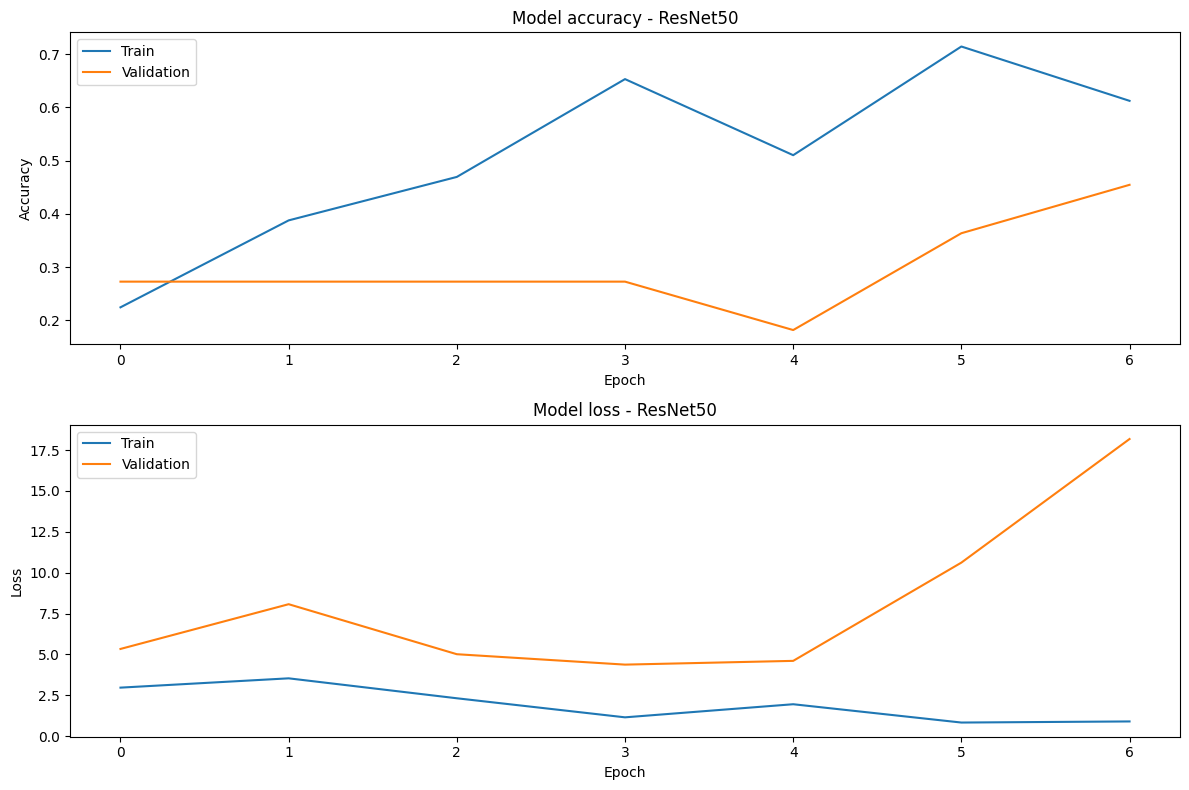

ResNet50 model and history saved in directory: ./split_datav3


In [3]:
import os
import numpy as np
import h5py
from sklearn.model_selection import train_test_split
from collections import Counter
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import matplotlib.pyplot as plt
import json

# Define a custom callback to print messages and store history
class PrintLogger(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"\nEpoch {epoch + 1} started.")
    
    def on_epoch_end(self, epoch, logs=None):
        print(f"\nEpoch {epoch + 1} ended.")
        print(f"Accuracy: {logs['accuracy']:.4f} - Loss: {logs['loss']:.4f} - Val Accuracy: {logs['val_accuracy']:.4f} - Val Loss: {logs['val_loss']:.4f}")

# Define directories
save_dir = './split_datav3'
os.makedirs(save_dir, exist_ok=True)

# Load the split data
X_rp_train = np.load(os.path.join(save_dir, 'X_rp_train.npy'))
X_gaf_train = np.load(os.path.join(save_dir, 'X_gaf_train.npy'))
X_mtf_train = np.load(os.path.join(save_dir, 'X_mtf_train.npy'))
y_train = np.load(os.path.join(save_dir, 'y_train.npy'))

X_rp_val = np.load(os.path.join(save_dir, 'X_rp_val.npy'))
X_gaf_val = np.load(os.path.join(save_dir, 'X_gaf_val.npy'))
X_mtf_val = np.load(os.path.join(save_dir, 'X_mtf_val.npy'))
y_val = np.load(os.path.join(save_dir, 'y_val.npy'))

X_rp_test = np.load(os.path.join(save_dir, 'X_rp_test.npy'))
X_gaf_test = np.load(os.path.join(save_dir, 'X_gaf_test.npy'))
X_mtf_test = np.load(os.path.join(save_dir, 'X_mtf_test.npy'))
y_test = np.load(os.path.join(save_dir, 'y_test.npy'))

# Resize images to (224, 224, 3) and keep only RGB channels
def resize_images(images):
    resized_images = []
    for img in images:
        img = tf.image.resize(img, [224, 224])
        img = img[:, :, :3]  # Keep only RGB channels
        resized_images.append(img)
    return np.array(resized_images)

X_rp_train = resize_images(X_rp_train)
X_gaf_train = resize_images(X_gaf_train)
X_mtf_train = resize_images(X_mtf_train)
X_rp_val = resize_images(X_rp_val)
X_gaf_val = resize_images(X_gaf_val)
X_mtf_val = resize_images(X_mtf_val)
X_rp_test = resize_images(X_rp_test)
X_gaf_test = resize_images(X_gaf_test)
X_mtf_test = resize_images(X_mtf_test)

# Define a function to build the ResNet50 model
def build_resnet50_model(input_shape, num_classes):
    inputs_rp = Input(shape=input_shape, name='input_rp')
    inputs_gaf = Input(shape=input_shape, name='input_gaf')
    inputs_mtf = Input(shape=input_shape, name='input_mtf')
    
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    
    # Create separate models for each input with unique names
    base_rp = Model(inputs=inputs_rp, outputs=base_model(inputs_rp), name='resnet50_rp')
    base_gaf = Model(inputs=inputs_gaf, outputs=base_model(inputs_gaf), name='resnet50_gaf')
    base_mtf = Model(inputs=inputs_mtf, outputs=base_model(inputs_mtf), name='resnet50_mtf')
    
    x_rp = base_rp.output
    x_rp = GlobalAveragePooling2D()(x_rp)
    
    x_gaf = base_gaf.output
    x_gaf = GlobalAveragePooling2D()(x_gaf)
    
    x_mtf = base_mtf.output
    x_mtf = GlobalAveragePooling2D()(x_mtf)
    
    merged = Concatenate()([x_rp, x_gaf, x_mtf])
    
    x = Dense(512, activation='relu', name='dense_512')(merged)
    x = Dropout(0.5, name='dropout_512')(x)
    x = Dense(128, activation='relu', name='dense_128')(x)
    x = Dropout(0.5, name='dropout_128')(x)
    outputs = Dense(num_classes, activation='softmax', name='output')(x)
    
    model = Model(inputs=[inputs_rp, inputs_gaf, inputs_mtf], outputs=outputs)
    return model

# Define input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 5

# Build ResNet50 model
resnet50_model = build_resnet50_model(input_shape, num_classes)
resnet50_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
resnet50_checkpoint = ModelCheckpoint(filepath=os.path.join(save_dir, 'resnet50_best_model.keras'), monitor='val_loss', save_best_only=True)

# Train ResNet50 model
resnet50_history = resnet50_model.fit(
    [X_rp_train, X_gaf_train, X_mtf_train], y_train,
    epochs=10, batch_size=32, validation_data=([X_rp_val, X_gaf_val, X_mtf_val], y_val),
    callbacks=[early_stopping, resnet50_checkpoint, PrintLogger()],
    verbose=1
)

# Evaluate ResNet50 model on the test set
resnet50_model.load_weights(os.path.join(save_dir, 'resnet50_best_model.keras'))
resnet50_test_loss, resnet50_test_accuracy = resnet50_model.evaluate([X_rp_test, X_gaf_test, X_mtf_test], y_test)
print(f'ResNet50 Test loss: {resnet50_test_loss:.4f}')
print(f'ResNet50 Test accuracy: {resnet50_test_accuracy:.4f}')

# Function to plot learning curves
def plot_learning_curve(history, model_name):
    plt.figure(figsize=(12, 8))

    # Plot training & validation accuracy values
    plt.subplot(2, 1, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model accuracy - {model_name}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model loss - {model_name}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Plot learning curve for ResNet50
plot_learning_curve(resnet50_history, 'ResNet50')

# Save the final ResNet50 model
resnet50_model.save(os.path.join(save_dir, 'resnet50_model.keras'))

# Save the training history
with open(os.path.join(save_dir, 'resnet50_history.json'), 'w') as f:
    json.dump(resnet50_history.history, f)

print(f"ResNet50 model and history saved in directory: {save_dir}")
